# Preços de carro no Brasil

Exploração das variações de preço de carro no Brasil e possíveis fatores relacionados

In [1]:
# importando bibliotecas

import numpy as np           
import pandas as pd
import matplotlib.pyplot as plt

# formatações e opções
%matplotlib inline
pd.options.display.float_format = '{:.4f}'.format

## Preparando os dados

Importando e tratando dados utilizados para a investigação

### Dados da tabela FIPE - preços de 2021 a 2023

In [2]:
# carregando o dataset da FIPE
df = pd.read_csv ('data/fipe_cars.csv')
df.head()

,year_of_reference,month_of_reference,fipe_code,authentication,brand,model,fuel,gear,engine_size,year_model,avg_price_brl
0,2021,January,038001-6,tlp4qry07m,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000
1,2021,January,038001-6,s1wksdv9by,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000
2,2021,January,038001-6,skrbcfnkch,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000
3,2021,January,038001-6,rxzh76d5db,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000
4,2021,January,038001-6,qrm322tpd8,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000


In [3]:
# checando consistência dos dados

print(f'Linhas: {df.shape[0]}')
print(f'Colunas (features): {df.shape[1]}')
print(f'Linhas duplicadas: {df.duplicated().sum()}')
print(f'Dados faltantes: {sum(df.isna().sum())}')

Linhas: 599007
Colunas (features): 11
Linhas duplicadas: 3
Dados faltantes: 0


In [4]:
# retirando valores duplicados

df.drop_duplicates(keep='first',inplace=True)
print(f'Linhas: {df.shape[0]}')
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas: 599004
Linhas duplicadas: 0


In [5]:
# adicionando coluna reference_date juntando year_of_reference e month_of_reference
df['reference_date'] = pd.to_datetime(df['month_of_reference'] + ' ' + df['year_of_reference'].astype(str), format='%B %Y')

# adicionando coluna age_model
df['age_model'] = df['year_of_reference'] - df['year_model']

# descartando fipe_code, authentication, year_of_reference, month_of_reference
df.drop(['fipe_code', 'authentication', 'year_of_reference', 'month_of_reference'], axis=1, inplace=True)
df.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000,2021-01-01,26
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000,2021-01-01,27
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000,2021-01-01,28
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000,2021-01-01,29
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000,2021-01-01,30


In [6]:
# estatísticas sobre cada feature
df.describe()

,engine_size,year_model,avg_price_brl,reference_date,age_model
count,599004.0000,599004.0000,599004.0000,599004,599004.0000
mean,2.2667,2008.7518,111580.9137,2022-01-03 04:39:40.960394240,12.8146
min,0.7000,1985.0000,1679.0000,2021-01-01 00:00:00,-1.0000
25%,1.6000,2001.0000,20150.0000,2021-07-01 00:00:00,5.0000
50%,2.0000,2010.0000,42988.5000,2022-01-01 00:00:00,11.0000
75%,2.8000,2016.0000,96921.2500,2022-07-01 00:00:00,20.0000
max,6.7000,2023.0000,8600000.0000,2023-01-01 00:00:00,38.0000
std,1.0320,9.1883,291224.4325,NaN,9.1958


In [7]:
# retirando outliers de preço
lower_bound = df['avg_price_brl'].quantile(0.05)
upper_bound = df['avg_price_brl'].quantile(0.95)
df = df[(df['avg_price_brl'] >= lower_bound) & (df['avg_price_brl'] <= upper_bound)]

# descrevendo novamente
df.describe()

,engine_size,year_model,avg_price_brl,reference_date,age_model
count,539109.0000,539109.0000,539109.0000,539109,539109.0000
mean,2.2151,2009.0730,71218.0108,2022-01-04 04:49:33.305954816,12.4958
min,1.0000,1985.0000,7734.0000,2021-01-01 00:00:00,-1.0000
25%,1.6000,2002.0000,21963.0000,2021-07-01 00:00:00,6.0000
50%,2.0000,2010.0000,42988.0000,2022-01-01 00:00:00,11.0000
75%,2.6000,2016.0000,88095.0000,2022-07-01 00:00:00,19.0000
max,6.7000,2023.0000,409699.0000,2023-01-01 00:00:00,38.0000
std,0.9763,8.5530,75648.9354,NaN,8.5754


### Corrigindo a inflação

Com a ajuda de um índice, as séries podem ser corrigidas para retirar o efeito da inflação. Os dados então são tratados para utilizar como base o valor do real em Janeiro de 2023.

Também será importada aqui a série com as conversões dólar-real, que serão utilizadas futuramente para conversão.

In [8]:
inflacao = pd.read_csv('data/ipca_indice.csv', delimiter=';')
inflacao.head()

,Data,IPCA - geral - índice (dez 1993 = 100)
0,2021/01,5574.4900
1,2021/02,5622.4300
2,2021/03,5674.7200
3,2021/04,5692.3100
4,2021/05,5739.5600


In [9]:
dolar = pd.read_csv('data/preco_dolar.csv', delimiter=';')
dolar.columns = ['reference_date', 'dollar_price']
dolar['reference_date'] = pd.to_datetime(dolar['reference_date'], format='%d.%m.%Y')
dolar.head()

,reference_date,dollar_price
0,2023-01-01,5.0731
1,2022-12-01,5.2860
2,2022-11-01,5.1851
3,2022-10-01,5.1791
4,2022-09-01,5.4154


In [10]:
# adicionando coluna reference_date
inflacao['reference_date'] = pd.to_datetime(inflacao['Data'], format='%Y/%m')

# ajustando índice
idx_2023_01 = inflacao['IPCA - geral - índice (dez 1993 = 100)'][24]
inflacao['ipca_index'] = inflacao['IPCA - geral - índice (dez 1993 = 100)']/idx_2023_01

inflacao.drop(['Data', 'IPCA - geral - índice (dez 1993 = 100)'], axis=1, inplace=True)
inflacao.head()

,reference_date,ipca_index
0,2021-01-01,0.8565
1,2021-02-01,0.8639
2,2021-03-01,0.8719
3,2021-04-01,0.8746
4,2021-05-01,0.8819


In [11]:
# juntando índice da inflação com dataframe original
df = pd.merge(df, inflacao, how='left', on='reference_date')
df.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model,ipca_index
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,40374.0000,2021-01-01,26,0.8565
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,38939.0000,2021-01-01,27,0.8565
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,37648.0000,2021-01-01,28,0.8565
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,35962.0000,2021-01-01,29,0.8565
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,32863.0000,2021-01-01,30,0.8565


## Extraindo séries dos dados

Agora que temos um dataframe tratado com dados da tabela FIPE, podemos retirar algumas séries temporais destes dados.

Isso será útil para relacionar estes dados com valores externos às características dos carros, como séries de preços de commodities.

In [12]:
df['fuel'].value_counts()

fuel
Gasoline    438453
Diesel       93338
Alcohol       7318
Name: count, dtype: int64

In [13]:
df['gear'].value_counts()

gear
manual       386500
automatic    152609
Name: count, dtype: int64

In [14]:
df['age_model'].value_counts()

age_model
 7     24299
 9     23999
 8     23854
 6     23419
 10    23367
 11    21938
 5     21702
 4     20767
 12    20751
 3     19816
 13    19024
-1     18729
 2     18569
 14    17694
 15    17004
 1     16701
 21    16447
 16    16259
 0     16234
 22    15911
 20    15649
 17    14876
 23    14760
 19    14531
 18    14252
 24    12409
 25    10328
 26    10304
 27     9681
 28     7468
 29     5727
 30     4129
 31     2507
 32     1560
 33     1287
 34     1080
 35      958
 36      751
 37      342
 38       26
Name: count, dtype: int64

In [15]:
# corrigindo valores
df_timeseries = df.copy()
df_timeseries['avg_price_brl'] = df_timeseries['avg_price_brl']*df_timeseries['ipca_index'] 
df_timeseries.drop(['ipca_index'], axis=1, inplace=True)
df_timeseries.head()

,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,reference_date,age_model
0,Acura,NSX 3.0,Gasoline,manual,3.0000,1995,34580.6126,2021-01-01,26
1,Acura,NSX 3.0,Gasoline,manual,3.0000,1994,33351.5251,2021-01-01,27
2,Acura,NSX 3.0,Gasoline,manual,3.0000,1993,32245.7746,2021-01-01,28
3,Acura,NSX 3.0,Gasoline,manual,3.0000,1992,30801.7039,2021-01-01,29
4,Acura,NSX 3.0,Gasoline,manual,3.0000,1991,28147.3887,2021-01-01,30


In [16]:
# agrupando dados por reference_date
df_timeseries = df_timeseries.groupby('reference_date').agg(
    # preço médio geral dos carros
    car_prices=('avg_price_brl', 'mean'),

    # preço médio dos carros a gasolina
    car_prices_gasoline=('avg_price_brl', lambda x: x[df['fuel'] == 'Gasoline'].mean()),

    # preço médio dos carros a diesel
    car_prices_diesel=('avg_price_brl', lambda x: x[df['fuel'] == 'Diesel'].mean()),

    # preço médio dos carros a álcool
    car_prices_alcohol=('avg_price_brl', lambda x: x[df['fuel'] == 'Alcohol'].mean()),

    # preço médio dos carros automáticos
    car_prices_automatic=('avg_price_brl', lambda x: x[df['gear'] == 'automatic'].mean()),

    # preço médio dos carros manuais
    car_prices_manual=('avg_price_brl', lambda x: x[df['gear'] == 'manual'].mean()),

    # preço médio dos carros 'novos' (ano de lançamento e 2 anteriores)
    car_prices_new=('avg_price_brl', lambda x: x[df['age_model'] <= 1].mean()),

    # preço médio dos carros 'antigos' (10 anos ou mais)
    car_prices_old=('avg_price_brl', lambda x: x[df['age_model'] >= 10].mean())
).reset_index()

# ordenando por reference_date
df_timeseries = df_timeseries.sort_values(by='reference_date')

df_timeseries.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old
0,2021-01-01,53776.6482,51308.2005,68473.0172,9331.7029,76385.6505,44910.4319,114608.4493,28679.8451
1,2021-02-01,54555.3488,52056.6713,69442.6110,9405.0226,77626.5528,45494.5738,117085.1328,28981.8677
2,2021-03-01,55507.8462,52891.8125,71022.8822,9487.5976,79061.1630,46198.4087,119099.6565,29404.0087
3,2021-04-01,56686.6612,53751.5295,73648.9934,9482.2750,80805.9186,47144.9770,121387.2569,29839.1156
4,2021-05-01,57721.3796,54588.6988,75584.1315,9556.0041,82155.6246,48028.5230,123740.8406,30278.9371


### Visualização das séries extraídas

Agora, podemos plotar algumas dessas séries e observar suas características.

In [17]:
# dataframe normalizado para que o 'desenho' das séries seja melhor comparado em gráficos com múltiplas séries
# cada série se torna um crescimento percentual relativo ao dado inicial

df_normalized_ts = df_timeseries.copy()
for col in df_normalized_ts.columns:
    if col == "reference_date":
        continue
    df_first = df_normalized_ts[col][0]
    df_normalized_ts[col] = (df_normalized_ts[col] - df_first)/(df_first)

df_normalized_ts.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old
0,2021-01-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2021-02-01,0.0145,0.0146,0.0142,0.0079,0.0162,0.0130,0.0216,0.0105
2,2021-03-01,0.0322,0.0309,0.0372,0.0167,0.0350,0.0287,0.0392,0.0252
3,2021-04-01,0.0541,0.0476,0.0756,0.0161,0.0579,0.0498,0.0591,0.0404
4,2021-05-01,0.0734,0.0639,0.1039,0.0240,0.0755,0.0694,0.0797,0.0558


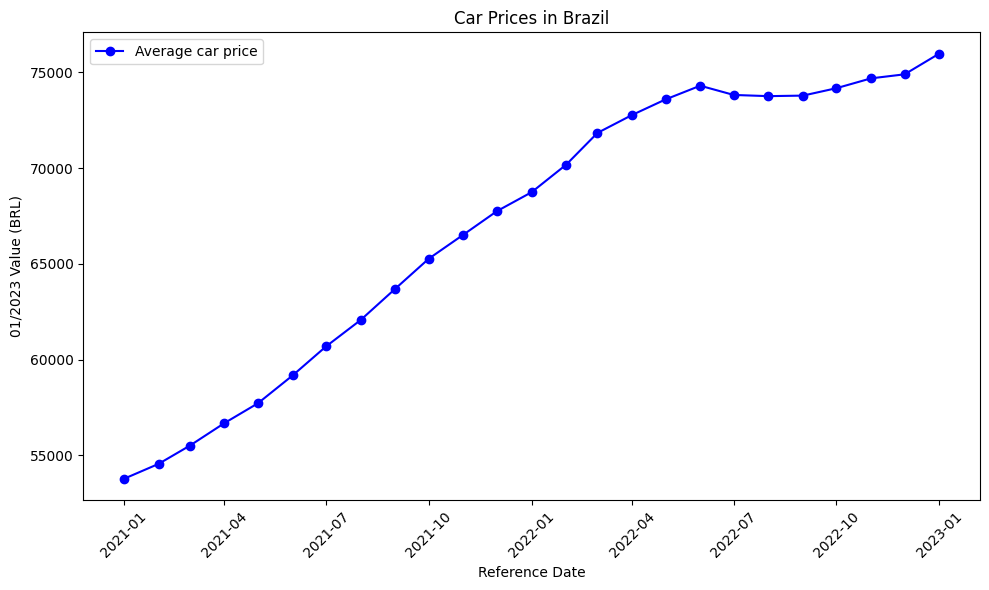

In [18]:
plt.figure(figsize=(10, 6))

# average car price series
plt.plot(df_timeseries['reference_date'], df_timeseries['car_prices'], label='Average car price', color='blue', marker='o')

# Add labels and title
plt.xlabel('Reference Date')
plt.ylabel('01/2023 Value (BRL)')
plt.title('Car Prices in Brazil')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Neste primeiro gráfico já é possível perceber que o preço médio dos carros cresceu consideravelmente, mesmo se ajustado para inflação do período.

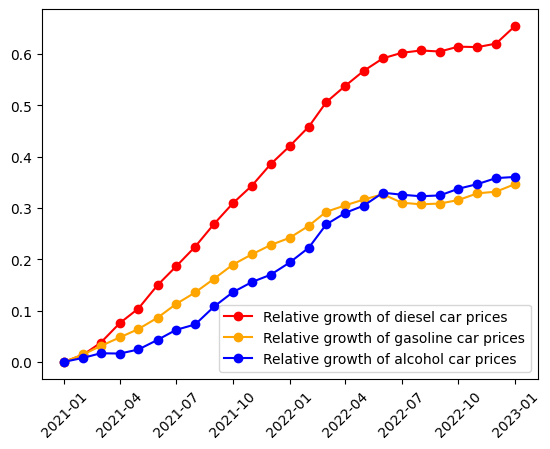

In [19]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_diesel'], label='Relative growth of diesel car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_gasoline'], label='Relative growth of gasoline car prices', color='orange', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_alcohol'], label='Relative growth of alcohol car prices', color='blue', marker='o')


# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O preço dos carros a diesel observou um crescimento consideravelmente maior que os outros carros, um aumento de mais de 60% no período sem a inflação.

Os carros a álcool e gasolina observaram um aumento parecido, em torno de 35% no período.

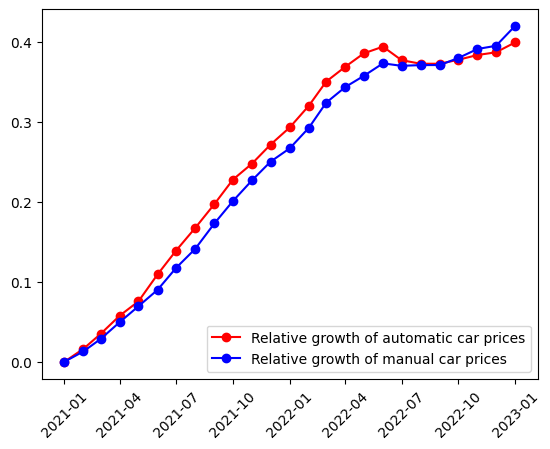

In [20]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_automatic'], label='Relative growth of automatic car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_manual'], label='Relative growth of manual car prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O crescimento relativo de preço de carros automáticos e manuais foi praticamente igual.

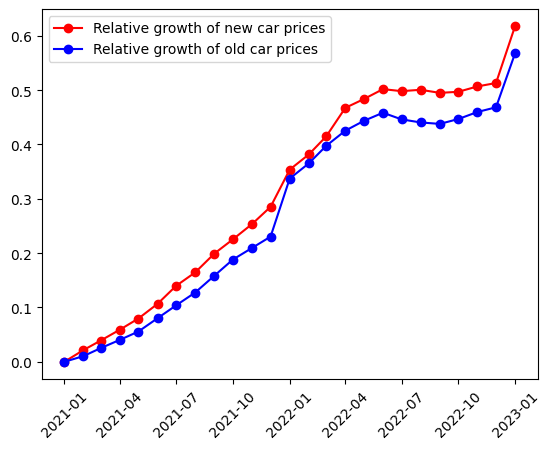

In [21]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_new'], label='Relative growth of new car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_old'], label='Relative growth of old car prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

O crescimento relativo de preço de carros novos (ano de lançamento + 2 anteriores) e antigos (10+ anos) foi praticamente igual, com uma leve liderança dos carros novos.

## Incluindo outros dados

Agora, outras séries temporais são incluídas para fim de comparação com as séries de preços de carro.

In [22]:
# série combustíveis
combustiveis = pd.read_csv('data/combustiveis-brasil.csv', delimiter=';')
combustiveis.head()

,data,etanol hidratado,gasolina comum,óleo diesel
0,01/01/2021,3.2210,4.6220,3.6960
1,01/02/2021,3.4290,4.9510,3.9510
2,01/03/2021,4.0380,5.4840,4.2520
3,01/04/2021,3.8260,5.4480,4.2020
4,01/05/2021,4.2500,5.6040,4.4700


In [23]:
# renomeando colunas
combustiveis.columns = ['reference_date', 'alcohol_price', 'gasoline_price', 'diesel_price']

# adicionando coluna reference_date
combustiveis['reference_date'] = pd.to_datetime(combustiveis['reference_date'], format='%d/%m/%Y')

# ajustando inflação
combustiveis = pd.merge(combustiveis, inflacao, how='left', on='reference_date')
combustiveis['alcohol_price'] = combustiveis['alcohol_price']*combustiveis['ipca_index']
combustiveis['gasoline_price'] = combustiveis['gasoline_price']*combustiveis['ipca_index'] 
combustiveis['diesel_price'] = combustiveis['diesel_price']*combustiveis['ipca_index']
combustiveis.drop(['ipca_index'], axis=1, inplace=True)

df_timeseries = pd.merge(df_timeseries, combustiveis, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price
0,2021-01-01,53776.6482,51308.2005,68473.0172,9331.7029,76385.6505,44910.4319,114608.4493,28679.8451,2.7588,3.9588,3.1656
1,2021-02-01,54555.3488,52056.6713,69442.6110,9405.0226,77626.5528,45494.5738,117085.1328,28981.8677,2.9622,4.2770,3.4132
2,2021-03-01,55507.8462,52891.8125,71022.8822,9487.5976,79061.1630,46198.4087,119099.6565,29404.0087,3.5208,4.7815,3.7073
3,2021-04-01,56686.6612,53751.5295,73648.9934,9482.2750,80805.9186,47144.9770,121387.2569,29839.1156,3.3463,4.7649,3.6751
4,2021-05-01,57721.3796,54588.6988,75584.1315,9556.0041,82155.6246,48028.5230,123740.8406,30278.9371,3.7479,4.9420,3.9420


In [24]:
# série preço de aço
aco = pd.read_csv('data/preco_aco.csv', delimiter=';')
aco.head()

,Data,Preço aço
0,01.01.2023,788.0000
1,01.12.2022,744.0000
2,01.11.2022,655.0000
3,01.10.2022,713.0000
4,01.09.2022,776.0000


In [25]:
# renomeando colunas
aco.columns = ['reference_date', 'steel_price']

# adicionando coluna reference_date
aco['reference_date'] = pd.to_datetime(aco['reference_date'], format='%d.%m.%Y')

# ajustando dólar/inflação
aco = pd.merge(aco, dolar, how='left', on='reference_date')
aco = pd.merge(aco, inflacao, how='left', on='reference_date')

aco['steel_price'] = aco['steel_price']*aco['dollar_price']*aco['ipca_index']
aco.drop(['ipca_index', 'dollar_price'], axis=1, inplace=True)

df_timeseries = pd.merge(df_timeseries, aco, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price
0,2021-01-01,53776.6482,51308.2005,68473.0172,9331.7029,76385.6505,44910.4319,114608.4493,28679.8451,2.7588,3.9588,3.1656,5375.7911
1,2021-02-01,54555.3488,52056.6713,69442.6110,9405.0226,77626.5528,45494.5738,117085.1328,28981.8677,2.9622,4.2770,3.4132,6113.3088
2,2021-03-01,55507.8462,52891.8125,71022.8822,9487.5976,79061.1630,46198.4087,119099.6565,29404.0087,3.5208,4.7815,3.7073,6618.8750
3,2021-04-01,56686.6612,53751.5295,73648.9934,9482.2750,80805.9186,47144.9770,121387.2569,29839.1156,3.3463,4.7649,3.6751,7156.1294
4,2021-05-01,57721.3796,54588.6988,75584.1315,9556.0041,82155.6246,48028.5230,123740.8406,30278.9371,3.7479,4.9420,3.9420,7660.4818


In [26]:
# série venda de carros
car_sales = pd.read_csv('data/venda_carros.csv', delimiter=';')
car_sales.head()

,data,venda carros
0,01/02/1981,65251
1,01/03/1981,64065
2,01/04/1981,69042
3,01/05/1981,62966
4,01/06/1981,61271


In [27]:
# renomeando colunas
car_sales.columns = ['reference_date', 'car_sales']

# adicionando coluna reference_date
car_sales['reference_date'] = pd.to_datetime(car_sales['reference_date'], format='%d/%m/%Y')

df_timeseries = pd.merge(df_timeseries, car_sales, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales
0,2021-01-01,53776.6482,51308.2005,68473.0172,9331.7029,76385.6505,44910.4319,114608.4493,28679.8451,2.7588,3.9588,3.1656,5375.7911,180904
1,2021-02-01,54555.3488,52056.6713,69442.6110,9405.0226,77626.5528,45494.5738,117085.1328,28981.8677,2.9622,4.2770,3.4132,6113.3088,186718
2,2021-03-01,55507.8462,52891.8125,71022.8822,9487.5976,79061.1630,46198.4087,119099.6565,29404.0087,3.5208,4.7815,3.7073,6618.8750,208801
3,2021-04-01,56686.6612,53751.5295,73648.9934,9482.2750,80805.9186,47144.9770,121387.2569,29839.1156,3.3463,4.7649,3.6751,7156.1294,191853
4,2021-05-01,57721.3796,54588.6988,75584.1315,9556.0041,82155.6246,48028.5230,123740.8406,30278.9371,3.7479,4.9420,3.9420,7660.4818,206221


In [28]:
# série índice de semicondutores
semiconductor_index = pd.read_csv('data/semiconductor-index.csv', delimiter=',')
semiconductor_index.head()

,DATE,PCU33443344
0,2021-01-01,54.1000
1,2021-02-01,54.1000
2,2021-03-01,54.3000
3,2021-04-01,54.2000
4,2021-05-01,54.5000


In [29]:
# renomeando colunas
semiconductor_index.columns = ['reference_date', 'semiconductor_index']

# adicionando coluna reference_date
semiconductor_index['reference_date'] = pd.to_datetime(semiconductor_index['reference_date'], format='%Y-%m-%d')

# usando 2021-01 como índice (100)
semiconductor_index['semiconductor_index'] = 100*semiconductor_index['semiconductor_index']/semiconductor_index['semiconductor_index'][0]

df_timeseries = pd.merge(df_timeseries, semiconductor_index, how='inner', on='reference_date')
df_timeseries.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,53776.6482,51308.2005,68473.0172,9331.7029,76385.6505,44910.4319,114608.4493,28679.8451,2.7588,3.9588,3.1656,5375.7911,180904,100.0000
1,2021-02-01,54555.3488,52056.6713,69442.6110,9405.0226,77626.5528,45494.5738,117085.1328,28981.8677,2.9622,4.2770,3.4132,6113.3088,186718,100.0000
2,2021-03-01,55507.8462,52891.8125,71022.8822,9487.5976,79061.1630,46198.4087,119099.6565,29404.0087,3.5208,4.7815,3.7073,6618.8750,208801,100.3697
3,2021-04-01,56686.6612,53751.5295,73648.9934,9482.2750,80805.9186,47144.9770,121387.2569,29839.1156,3.3463,4.7649,3.6751,7156.1294,191853,100.1848
4,2021-05-01,57721.3796,54588.6988,75584.1315,9556.0041,82155.6246,48028.5230,123740.8406,30278.9371,3.7479,4.9420,3.9420,7660.4818,206221,100.7394


## Observando novos dados em relação aos preços de automóveis

Agora, podemos observar relações entre os dados importados e os preços de automóveis.

In [30]:
# dataset de mudanças percentuais em relação ao valor inicial
df_percentual_ts = df_timeseries.copy()
for col in df_percentual_ts.columns:
    if col == "reference_date":
        continue
    df_first = df_percentual_ts[col][0]
    df_percentual_ts[col] = (df_percentual_ts[col] - df_first)/(df_first)

df_percentual_ts.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2021-02-01,0.0145,0.0146,0.0142,0.0079,0.0162,0.0130,0.0216,0.0105,0.0737,0.0804,0.0782,0.1372,0.0321,0.0000
2,2021-03-01,0.0322,0.0309,0.0372,0.0167,0.0350,0.0287,0.0392,0.0252,0.2762,0.2078,0.1711,0.2312,0.1542,0.0037
3,2021-04-01,0.0541,0.0476,0.0756,0.0161,0.0579,0.0498,0.0591,0.0404,0.2129,0.2036,0.1609,0.3312,0.0605,0.0018
4,2021-05-01,0.0734,0.0639,0.1039,0.0240,0.0755,0.0694,0.0797,0.0558,0.3585,0.2484,0.2452,0.4250,0.1399,0.0074


In [58]:
# dataset normalizado em relação aos valores máx/mín
df_normalized_ts = df_timeseries.copy()
for col in df_normalized_ts.columns:
    if col == "reference_date":
        continue
    df_max = max(df_normalized_ts[col])
    df_min = min(df_normalized_ts[col])
    df_change = df_max - df_min
    df_normalized_ts[col] = 2*(df_normalized_ts[col] - df_min)/(df_change) - 1

df_normalized_ts.head()

,reference_date,car_prices,car_prices_gasoline,car_prices_diesel,car_prices_alcohol,car_prices_automatic,car_prices_manual,car_prices_new,car_prices_old,alcohol_price,gasoline_price,diesel_price,steel_price,car_sales,semiconductor_index
0,2021-01-01,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-0.3369,-0.0588,-1.0000
1,2021-02-01,-0.9299,-0.9158,-0.9567,-0.9564,-0.9186,-0.9381,-0.9301,-0.9629,-0.8349,-0.8031,-0.8817,-0.0946,0.0633,-1.0000
2,2021-03-01,-0.8441,-0.8218,-0.8862,-0.9073,-0.8246,-0.8634,-0.8732,-0.9111,-0.3817,-0.4910,-0.7410,0.0715,0.5272,-0.8859
3,2021-04-01,-0.7379,-0.7251,-0.7691,-0.9104,-0.7102,-0.7631,-0.8087,-0.8578,-0.5233,-0.5013,-0.7565,0.2480,0.1712,-0.9430
4,2021-05-01,-0.6447,-0.6309,-0.6827,-0.8666,-0.6217,-0.6694,-0.7423,-0.8038,-0.1973,-0.3917,-0.6289,0.4137,0.4730,-0.7719


### Preços de carros de diferentes combustíveis e preço dos combustíveis

Abaixo, podemos ver as relações entre as variações nos preços de combustíveis e seus respectivos veículos.
Nota-se que a relação é particularmente alta em relação aos carros que utilizam óleo diesel, combustível cujo preço mais cresceu.

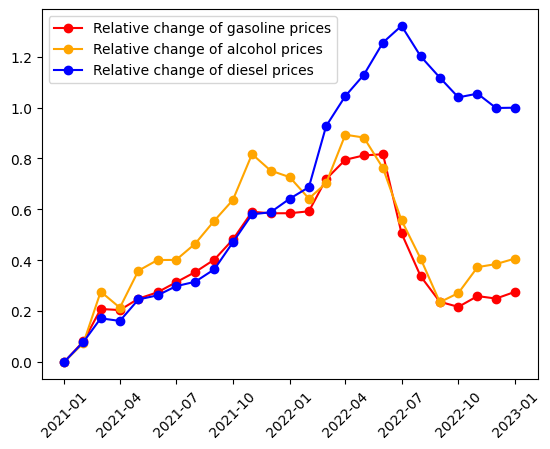

In [57]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['gasoline_price'], label='Relative change of gasoline prices', color='red', marker='o')
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['alcohol_price'], label='Relative change of alcohol prices', color='orange', marker='o')
plt.plot(df_percentual_ts['reference_date'], df_percentual_ts['diesel_price'], label='Relative change of diesel prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

In [52]:
# tabela de correlações: preços de carros de combustíveis e gasolinas
columns_fuel = ["car_prices_gasoline", "car_prices_diesel", "car_prices_alcohol", "gasoline_price", "diesel_price", "alcohol_price"]
fuel_correlation = df_timeseries[columns_fuel].corr()

fuel_correlation[:3][["gasoline_price", "diesel_price", "alcohol_price"]]

,gasoline_price,diesel_price,alcohol_price
car_prices_gasoline,0.5478,0.9547,0.5293
car_prices_diesel,0.4773,0.9677,0.4523
car_prices_alcohol,0.4234,0.9720,0.3825


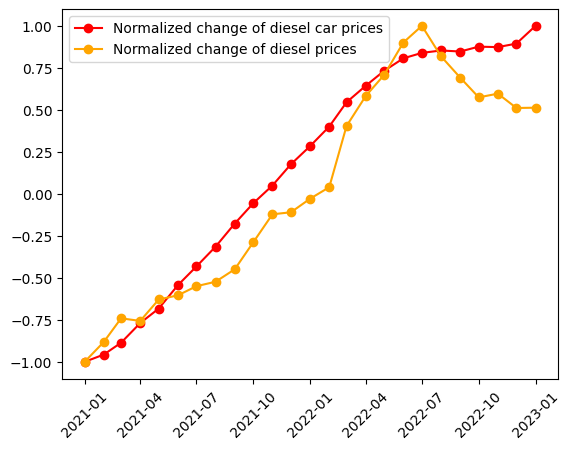

In [59]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_diesel'], label='Normalized change of diesel car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['diesel_price'], label='Normalized change of diesel prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

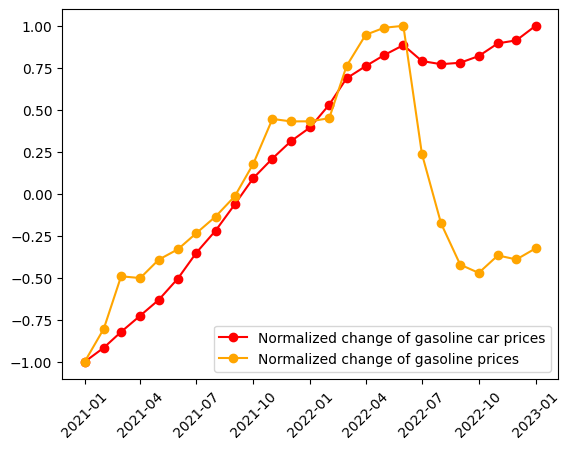

In [60]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_gasoline'], label='Normalized change of gasoline car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['gasoline_price'], label='Normalized change of gasoline prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

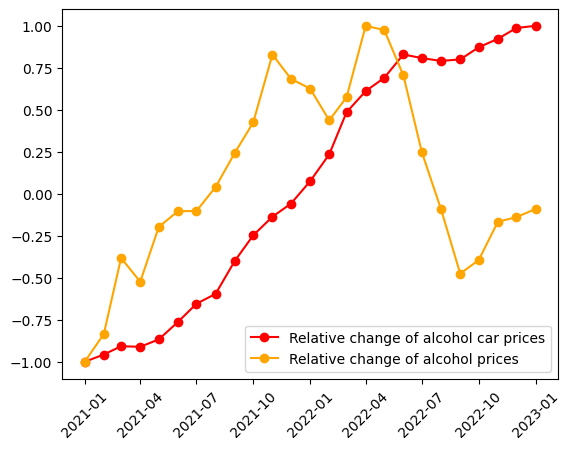

In [61]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices_alcohol'], label='Relative change of alcohol car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['alcohol_price'], label='Relative change of alcohol prices', color='orange', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()

### Preços dos carros relativo ao mercado do aço e semicondutores

Olhando as variações de preços de diferentes mercados com o mercado automobilístico, nota-se uma correlação muito alta entre o preço dos carros e o mercado de semicondutores. Isso também pode ser verificado visualmente através de suas séries normalizadas.

In [66]:
# tabela de correlações: preços de carros de combustíveis e gasolinas
columns_markets = ["car_prices", "car_sales", "steel_price", "semiconductor_index"]
market_correlation = df_timeseries[columns_markets].corr()

market_correlation[:2][["steel_price", "semiconductor_index", "car_sales"]]

,steel_price,semiconductor_index,car_sales
car_prices,-0.5882,0.9639,0.1171
car_sales,-0.3762,0.1605,1.0000


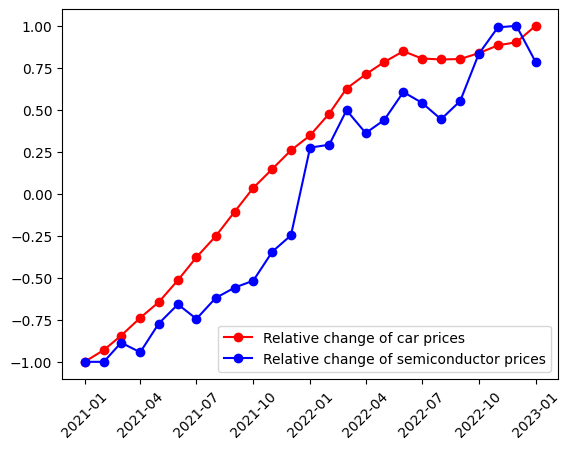

In [67]:
# Clear only the current axes (the data/series)
plt.gca().cla()

# Plot the new series (car prices for automatic and manual cars)
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['car_prices'], label='Relative change of car prices', color='red', marker='o')
plt.plot(df_normalized_ts['reference_date'], df_normalized_ts['semiconductor_index'], label='Relative change of semiconductor prices', color='blue', marker='o')

# Update the legend (since it's associated with the new series)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the updated plot
plt.draw()
plt.show()